In [ ]:
Полина Чижик, лабораторная работа №6

Исключение или дропаут (от англ. dropout) — метод регуляризации искусственных нейронных сетей, предназначен для уменьшения переобучения сети за счет предотвращения сложных коадаптаций отдельных нейронов на тренировочных данных во время обучения. Термин «dropout» (выбивание, выбрасывание) характеризует исключение определённого процента (например 30%) случайных нейронов (находящихся как в скрытых, так и видимых слоях) на разных итерациях (эпохах) во время обучения нейронной сети.

Регуляризация - метод добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Эта информация часто имеет вид штрафа за сложность модели.

In [ ]:
import torch
import torchvision.datasets

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)
X_test = torch.FloatTensor(CIFAR_test.data) 
y_test = torch.LongTensor(CIFAR_test.targets)
X_train = torch.FloatTensor(CIFAR_train.data) 
y_train = torch.LongTensor(CIFAR_train.targets) 
X_train /= 255.
X_test /= 255.
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class CIFARNet(torch.nn.Module):
    def __init__(self, dropout = 0.15):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        if dropout:
            self.batch_drop1 = torch.nn.Dropout(p=dropout, inplace=False)
            self.batch_drop2 = torch.nn.Dropout2d(p=dropout, inplace=False)
            self.dropout = dropout
        else:
            self.dropout = False
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        if self.dropout:
            x = self.batch_drop2(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        if self.dropout:
            x = self.batch_drop2(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        if self.dropout:
            x = self.batch_drop2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        if self.dropout:
            x = self.batch_drop2(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        if self.dropout:
            x = self.batch_drop1(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        if self.dropout:
            x = self.batch_drop1(x)
        x = self.fc3(x)
        return x

In [ ]:
def train(net,X_train, y_train, 
          X_test, y_test,
          device = 'cuda', 
          epochs = 30,
          grad_clip = 1,
          batch_size = 100):
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3,weight_decay=1e-5)
    test_accuracy_history = []
    test_loss_history = []
    train_loss_history = [] 
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(epochs):
        order = np.random.permutation(len(X_train)) 
        train_epoch_loss_history = []
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
            train_epoch_loss_history.append(loss_value.cpu().item())
            optimizer.step()
        net.eval()
        with torch.no_grad(): 
             test_preds = net.forward(X_test)     
             test_loss_history.append(loss(test_preds, y_test).item())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
        test_accuracy_history.append(accuracy)
        train_loss_history.append(np.mean(train_epoch_loss_history))
        if epoch%10==0:
          print(f'Epoch: {epoch}, accuracy = {accuracy}');
    print(f'Max test accuracy {max(test_accuracy_history)}')
    return test_accuracy_history, test_loss_history

In [ ]:
torch.cuda.is_available()

True

1 задание

In [ ]:
net = CIFARNet(dropout=0)
test_accuracy_history, test_loss_history = train(
    net,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    device = 'cuda', 
    epochs = 20,
    grad_clip = 0,
    batch_size = 1024
)

Epoch: 0, accuracy = 0.5952999591827393
Epoch: 10, accuracy = 0.7001999616622925
---------------
Max test accuracy 0.7013999819755554
---------------


Максимальная точность предсказаний без дропаута - 70 %

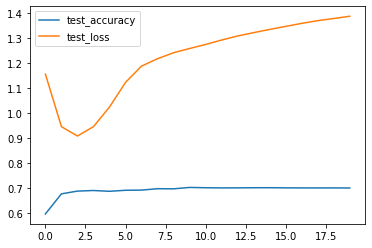

In [ ]:
pd.DataFrame(dict(test_accuracy = test_accuracy_history,test_loss = test_loss_history )).plot()

2 задание

Epoch: 0, accuracy = 0.47529998421669006
Epoch: 10, accuracy = 0.7060999870300293
Epoch: 20, accuracy = 0.7197999954223633
Epoch: 30, accuracy = 0.7127000093460083
---------------
Max test accuracy 0.723800003528595
---------------


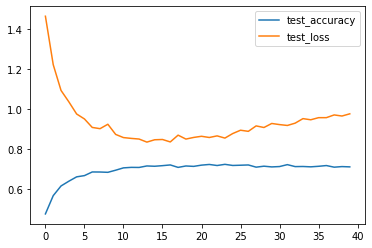

In [ ]:
net = CIFARNet(dropout=0.15)

test_accuracy_history, test_loss_history = train(
    net,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    device = 'cuda', 
    epochs = 40,
    grad_clip = 0,
    batch_size = 1024
)

pd.DataFrame(dict(test_accuracy = test_accuracy_history,test_loss = test_loss_history)).plot()

In [ ]:
После добавления дропаута со значением 0.15 качество предсказаний сети выросло 

Epoch: 0, accuracy = 0.29019999504089355
Epoch: 10, accuracy = 0.49959999322891235
Epoch: 20, accuracy = 0.5640999674797058
Epoch: 30, accuracy = 0.5938000082969666
Epoch: 40, accuracy = 0.6186999678611755
Epoch: 50, accuracy = 0.626800000667572
Epoch: 60, accuracy = 0.6437000036239624
Epoch: 70, accuracy = 0.6452999711036682
Epoch: 80, accuracy = 0.6541999578475952
Epoch: 90, accuracy = 0.6561999917030334
Epoch: 100, accuracy = 0.6688999533653259
Epoch: 110, accuracy = 0.6694999933242798
Epoch: 120, accuracy = 0.6735000014305115
Epoch: 130, accuracy = 0.6735000014305115
Epoch: 140, accuracy = 0.6776999831199646
Epoch: 150, accuracy = 0.6800999641418457
Epoch: 160, accuracy = 0.6833999752998352
Epoch: 170, accuracy = 0.6832999587059021
Epoch: 180, accuracy = 0.6924999952316284
Epoch: 190, accuracy = 0.6937999725341797
Epoch: 200, accuracy = 0.6933000087738037
Epoch: 210, accuracy = 0.6974999904632568
Epoch: 220, accuracy = 0.6951999664306641
Epoch: 230, accuracy = 0.7005999684333801
Ep

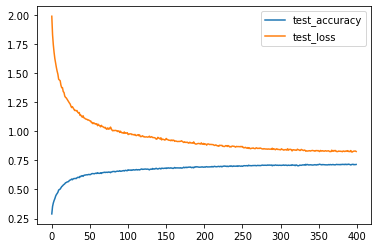

In [ ]:
net = CIFARNet(dropout=0.5)

test_accuracy_history, test_loss_history = train(
    net,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    device = 'cuda', 
    epochs = 400,
    grad_clip = 0,
    batch_size = 1024
)

pd.DataFrame(dict(test_accuracy = test_accuracy_history,test_loss = test_loss_history )).plot()

In [ ]:
preds = net.forward(X_test.cuda()).argmax(dim=1).cpu().detach()

После увеличения дропаута с 0.15 до 0.5 качество не выросло.

3 задание

In [ ]:
preds = pd.DataFrame([y_test.numpy(),preds.numpy()]).T

In [ ]:
preds[preds[0] != preds[1]].iloc[4]

0    5
1    4
Name: 24, dtype: int64

truck truck


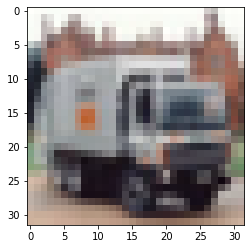

In [ ]:
plt.imshow(X_test[11].permute(1,2,0))
print(CIFAR_test.classes[y_test[11].item()],CIFAR_test.classes[preds[1][11]]) 

Опознано верно